In [1]:
import os
import os.path as op
import glob
import nibabel as nb
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nilearn import plotting

import urllib.request, zipfile
from pycocotools.coco import COCO

#from nsd_access import NSDAccess
from NSDS_Access import NSDSAccess

%matplotlib inline

In [2]:
nsdsa = NSDSAccess('/home/stone/kendrick/nsd/')

In [3]:
# get the betas for a given subject, session and set of trials
betas = nsdsa.read_betas(subject='subj01', 
                        trial_index=[], # empty list as index means get all for this session
                        data_type='nsdsyntheticbetas_fithrf_GLMdenoise_RR',
                        data_format='fsaverage')

print(betas.shape)

(327684, 744)


In [4]:
# just list the available atlases for a given subject/data format - returns a list of names
# will, for surfaces, mix both mapper results and atlas data.
atlases = nsdsa.list_atlases(subject='subj01', data_format='func1pt8mm');
# similar functionality should be created for mapper data when fsaverage mapper results exist.
atlases

Atlases found in /home/stone/kendrick/nsd/nsddata/ppdata/subj01/func1pt8mm/roi:
[   'rh.floc-bodies.nii.gz',
    'thalamus.nii.gz',
    'MTL.nii.gz',
    'lh.thalamus.nii.gz',
    'lh.corticalsulc.nii.gz',
    'Kastner2015.nii.gz',
    'fVTC.nii.gz',
    'rh.Kastner2015.nii.gz',
    'rh.fVTC.nii.gz',
    'rh.nsdgeneral.nii.gz',
    'lh.floc-words.nii.gz',
    'rh.prf-eccrois.nii.gz',
    'lh.MTL.nii.gz',
    'rh.prf-visualrois.nii.gz',
    'rh.corticalsulc.nii.gz',
    'rh.floc-places.nii.gz',
    'rh.floc-words.nii.gz',
    'floc-faces.nii.gz',
    'rh.HCP_MMP1.nii.gz',
    'floc-bodies.nii.gz',
    'rh.floc-faces.nii.gz',
    'rh.streams.nii.gz',
    'lh.fVTC.nii.gz',
    'floc-words.nii.gz',
    'corticalsulc.nii.gz',
    'lh.Kastner2015.nii.gz',
    'prf-visualrois.nii.gz',
    'floc-places.nii.gz',
    'prf-eccrois.nii.gz',
    'lh.streams.nii.gz',
    'lh.floc-places.nii.gz',
    'rh.visualsulc.nii.gz',
    'lh.floc-faces.nii.gz',
    'nsdgeneral.nii.gz',
    'HCP_MMP1.nii.gz',
 

array(['HCP_MMP1', 'Kastner2015', 'MTL', 'corticalsulc', 'fVTC',
       'floc-bodies', 'floc-faces', 'floc-places', 'floc-words',
       'nsdgeneral', 'prf-eccrois', 'prf-visualrois', 'streams',
       'thalamus', 'visualsulc'], dtype='<U14')

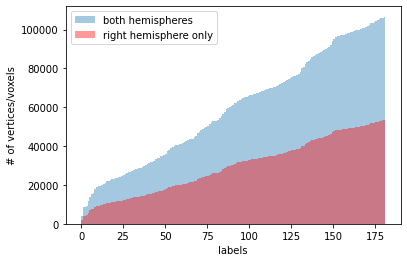

In [5]:
# get surface-based or volume-based atlas values and their mapping
# for now, demoing volume for lack of surface mapper results

atlas = 'HCP_MMP1'
mmp1, atlas_mapping = nsdsa.read_atlas_results(subject='subj01', 
                               atlas=atlas, 
                               data_format='func1pt8mm')
plt.hist(mmp1.ravel(), 
         range=[0,int(np.max(mmp1))+1],
         bins=int(np.max(mmp1))+1, 
         alpha=0.4, 
         cumulative=True, 
         label='both hemispheres');

# or, only get the right hemisphere
mmp1_rh, atlas_mapping_rh = nsdsa.read_atlas_results(subject='subj01', 
                               atlas=f'rh.{atlas}', 
                               data_format='func1pt8mm')
plt.hist(mmp1_rh.ravel(), 
         range=[0,int(np.max(mmp1))+1],
         bins=int(np.max(mmp1))+1, 
         alpha=0.4, 
         color='r', 
         cumulative=True, 
         label='right hemisphere only');
plt.gca().set_xlabel('labels')
plt.gca().set_ylabel('# of vertices/voxels')
plt.legend()

# easy to make, for example, V1 mask:
v1_mask = (mmp1 == atlas_mapping['V1'])
# or rh V1 mask
v1_mask_rh = (mmp1_rh == atlas_mapping_rh['V1'])

# you could:
# print(atlas_mapping)


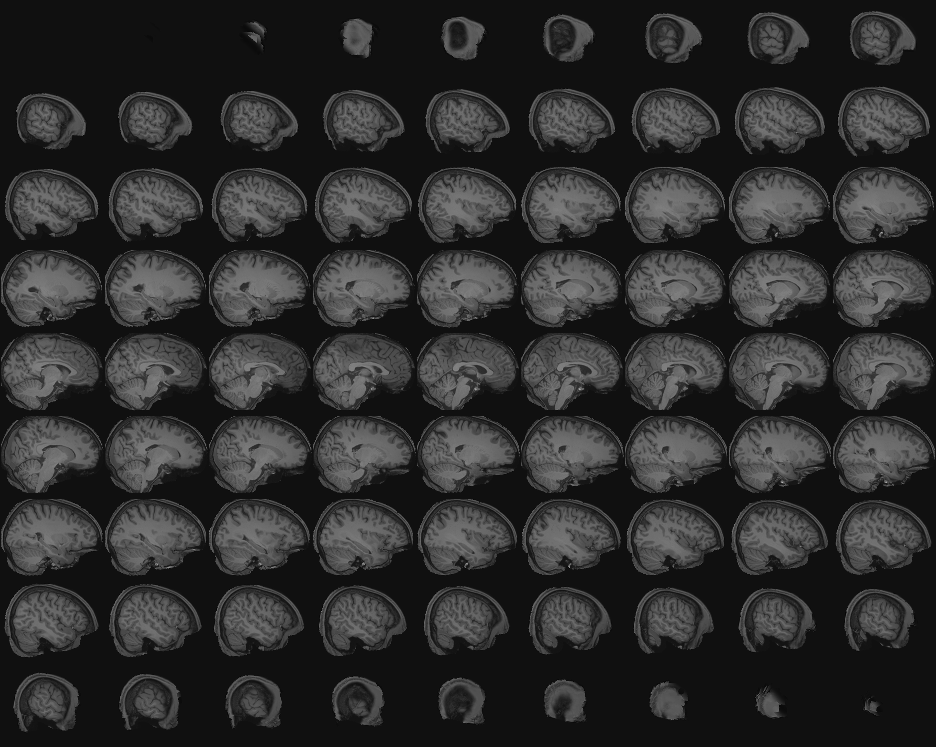
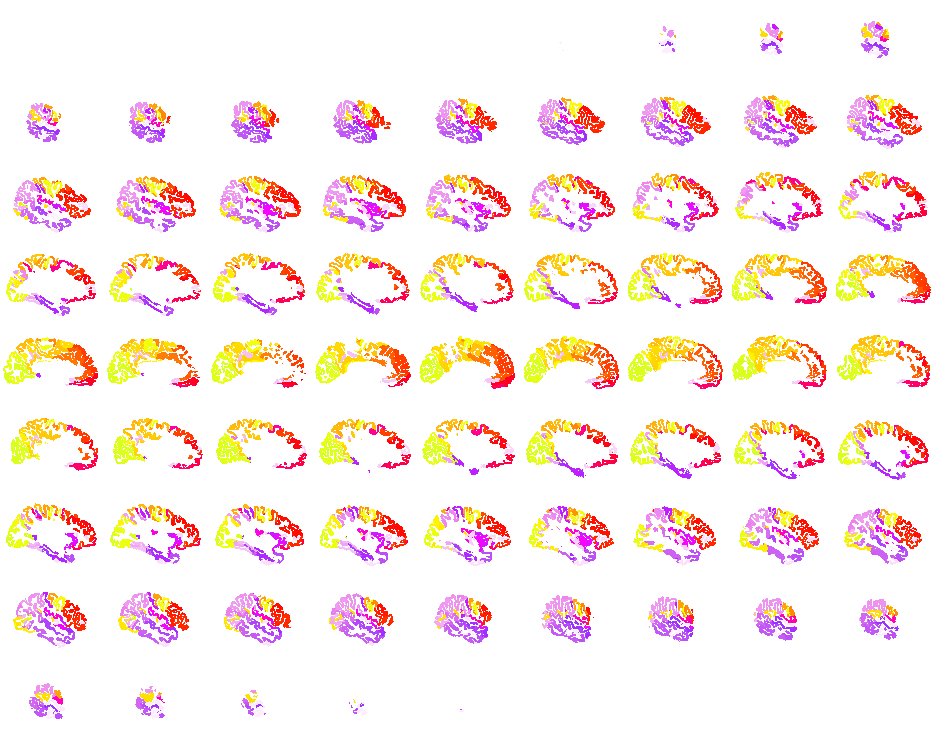

In [6]:

affine, header = nsdsa.affine_header(subject='subj01', data_format='func1mm')
mean_img = nsdsa.read_vol_ppdata(subject='subj01', 
                                filename='T1_to_func1pt8mm', 
                                data_format='func1pt8mm')

mmp1_masked = np.copy(mmp1)
mmp1_masked[mmp1==-1] = np.nan

plotting.view_img(nb.Nifti1Image(mmp1_masked, affine=affine, header=header), 
                  bg_img=nb.Nifti1Image(mean_img, affine=affine, header=header),
                  title="MMP1", 
                  display_mode='tiled', 
                  cmap='gist_ncar', 
                  vmax=180,
                  symmetric_colormap=False)

In [7]:
R2_img = nsdsa.read_vol_ppdata(subject='subj01', 
                                filename='R2', 
                                data_format='func1pt8mm')


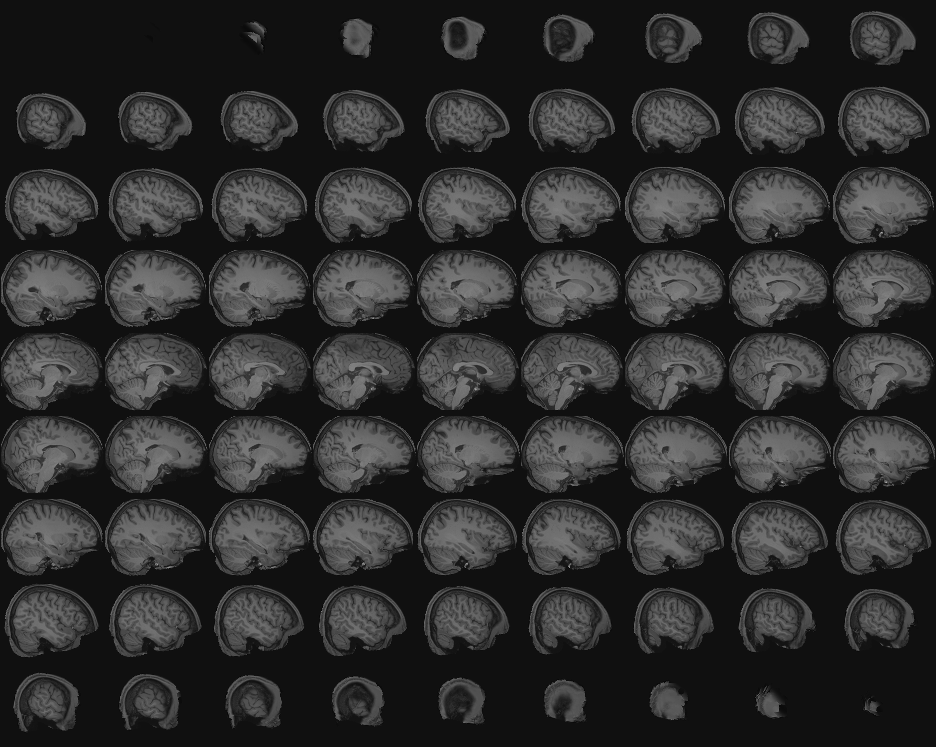
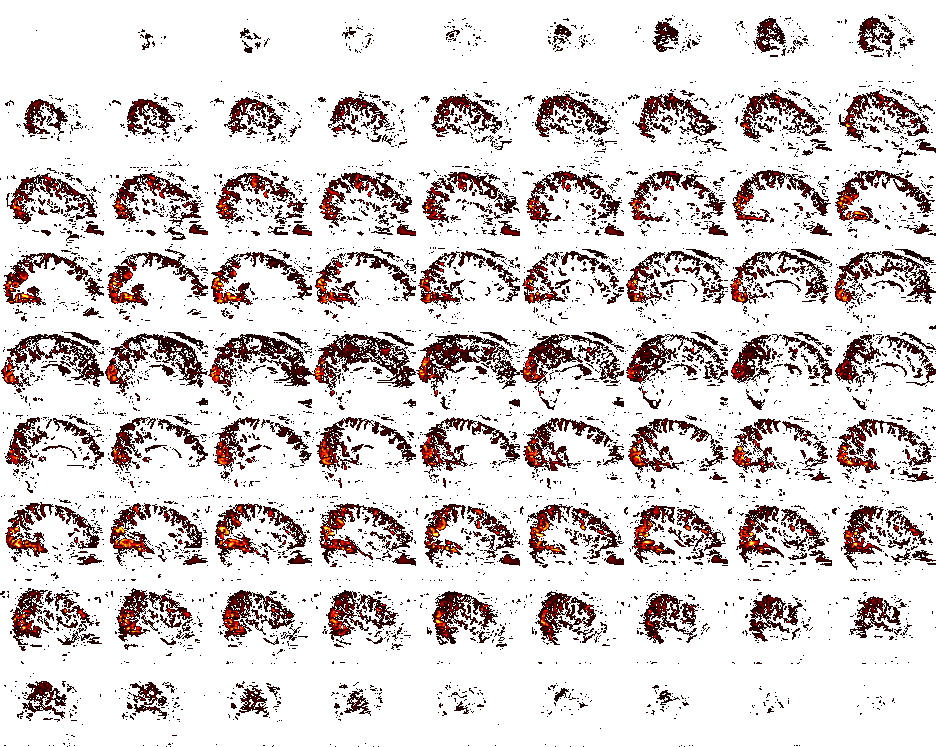

In [8]:
plotting.view_img(nb.Nifti1Image(R2_img, affine=affine, header=header), 
                  bg_img=nb.Nifti1Image(mean_img, affine=affine, header=header),
                  title="per-trial R2", 
                  display_mode='tiled', 
                  threshold=0.7)


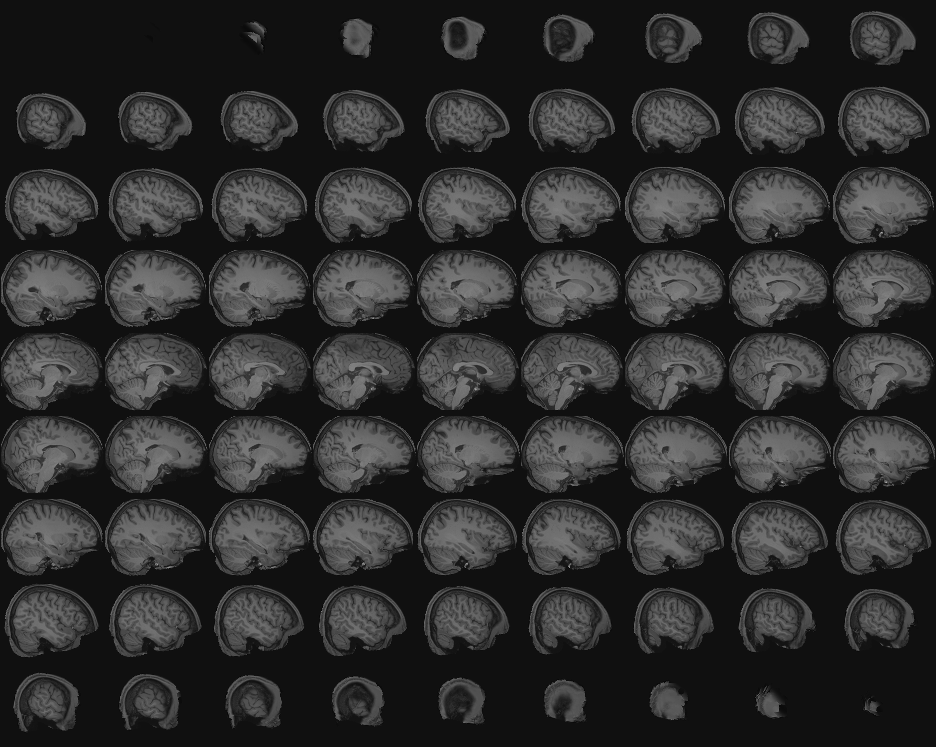
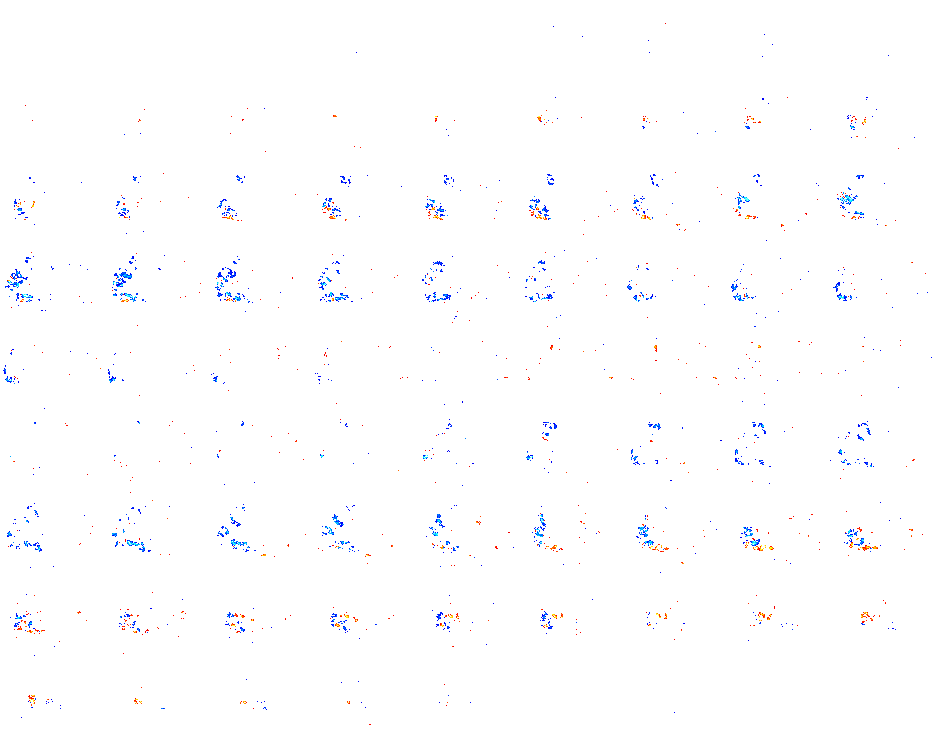

In [9]:
floc_faces_t = nsdsa.read_mapper_results(subject='subj01', 
                                        mapper='floc', 
                                        data_type='facestval', 
                                        data_format='func1pt8mm')

# but, these mapper data are not yet available for fsaverage
# nsdsa.read_mapper_results(subject='subj01', mapper='prf', data_type='angle', data_format='fsaverage')

plotting.view_img(nb.Nifti1Image(floc_faces_t, affine=affine, header=header), 
                  bg_img=nb.Nifti1Image(mean_img, affine=affine, header=header),
                  title="faces T value", 
                  display_mode='tiled', 
                  vmax=12,
                  threshold=4)

In [10]:
stim_df = nsdsa.stim_indexing()

/home/naxos2-raid14/ashar/Environments/NSDS_Access.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OnebackTrial'][a] = 0
/home/naxos2-raid14/ashar/Environments/NSDS_Access.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OnebackTrial'][a] = 1
/home/naxos2-raid14/ashar/Environments/NSDS_Access.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TaskType'][count] = 0
/home/naxos2-raid14/ashar/Environments/NSDS_Ac

In [11]:
stim_df.head(25)

ImageIndex  OnebackTrial  TaskType
0          198             0         0
1          231             0         0
2          196             0         0
3          152             0         0
4           53             0         0
5           18             0         0
6           23             0         0
7          180             0         0
8           25             0         0
9           34             0         0
10         221             0         0
11         240             0         0
12         202             0         0
13         141             0         0
14         108             0         0
15          52             0         0
16          14             0         0
17         249             0         0
18          24             0         0
19         203             0         0
20         149             1         0
21         149             1         0
22          12             0         0
23          23             0         0
24         112             0         0

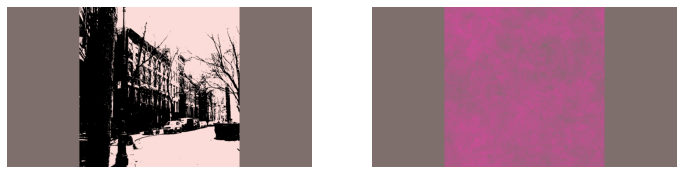

In [12]:
stim_img = nsdsa.read_images('subj01', [22, 230], show=True)